<a href="https://colab.research.google.com/github/VellummyilumVinoth/Aspect_based_sentimental_analysis/blob/main/Aspect_auto_categorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
!pip install transformers
!pip install --upgrade keras
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import keras.preprocessing.sequence
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.
  warnings.warn(
Xformers is not installed correctly. If you want to use memory_efficient_attentio

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

## Load and Preprocess Training Data

Dataset will be tokenized then split into training and validation sets. The validation set will be used to monitor training. For testing a separate test set will be loaded for analysis.

In [110]:
# Step 1: Prepare your dataset
df = pd.read_csv('/content/drive/MyDrive/zidan/aspect_extracted_file.csv')

In [111]:
# Assuming your dataset is stored in X and y variables
df, test_data = train_test_split(df, test_size=0.2)


In [33]:
df

,product_name,review,review_without_emoji,preprocess_text,preprocess_text1,aspects,price,quality,delivery cost,packaging,design,customer service,usability
10777,"95-96 Gallon Trash Bags (50/Bags w/Ties, Whole...","LOVE, LOVE, LOVE, not having nasty, dirty, sme...","LOVE, LOVE, LOVE, not having nasty, dirty, sme...",love love love not having nasty dirty smelly t...,"['love', 'love', 'love', 'nasty', 'dirty', 'sm...","['price', 'quality']",1,1,0,0,0,0,0
9394,"CELOX 24 Pack Durable Kitchen Sponges, Natural...","Couldn’t find these sponges else where, Amazon...","Couldn’t find these sponges else where, Amazon...",couldnt find these sponges else where amazon h...,"['couldnt', 'find', 'sponges', 'else', 'amazon...",[],0,0,0,0,0,0,0
5417,"Caboo Tree Free Bamboo Toilet Paper, Septic Sa...",I like the fact that trees are not cut down.,I like the fact that trees are not cut down.,i like the fact that trees are not cut down,"['like', 'fact', 'trees', 'cut']",[],0,0,0,0,0,0,0
10018,King Palm Mini Size Natural Pre Wrap Palm Leaf...,These things are amazing. Love the corn husk f...,These things are amazing. Love the corn husk f...,these things are amazing love the corn husk fi...,"['things', 'amazing', 'love', 'corn', 'husk', ...","['quality', 'design']",0,1,0,0,1,0,0
3489,"Electric Spin Scrubber, Leebein Cordless Clean...",i like how easy it is to put the brushes on an...,i like how easy it is to put the brushes on an...,i like how easy it is to put the brushes on an...,"['like', 'easy', 'put', 'brushes', 'comes', 'c...","['quality', 'design', 'usability']",0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2641,"Scotch-Brite Dishwand, Brush Scrubber for Clea...",was pleasantly surprised that it doesn't waste...,was pleasantly surprised that it doesn't waste...,was pleasantly surprised that it doesnt waste ...,"['pleasantly', 'surprised', 'doesnt', 'waste',...",['quality'],0,1,0,0,0,0,0
6937,iDesign Plastic Bath Squeegee for Glass with S...,"Squeegee is adequate. The suction cup, however...","Squeegee is adequate. The suction cup, however...",squeegee is adequate the suction cup however f...,"['squeegee', 'adequate', 'suction', 'cup', 'ho...",['delivery cost'],0,0,1,0,0,0,0
8408,"Hefty Ultra Strong Tall Kitchen Trash Bags, Fa...",The media could not be loaded.,The media could not be loaded.,the media could not be loaded,"['media', 'could', 'loaded']",[],0,0,0,0,0,0,0
3454,DynaTrap 41050 UV Replacement Bulb for DynaTra...,"No issues, works.","No issues, works.",no issues works,"['issues', 'works']",['quality'],0,1,0,0,0,0,0


In [34]:
columns_to_drop = ['product_name', 'review','review_without_emoji', 'aspects', 'preprocess_text1']
df.drop(columns_to_drop, axis=1, inplace=True)

In [35]:
df.head()

,preprocess_text,price,quality,delivery cost,packaging,design,customer service,usability
10777,love love love not having nasty dirty smelly t...,1,1,0,0,0,0,0
9394,couldnt find these sponges else where amazon h...,0,0,0,0,0,0,0
5417,i like the fact that trees are not cut down,0,0,0,0,0,0,0
10018,these things are amazing love the corn husk fi...,0,1,0,0,1,0,0
3489,i like how easy it is to put the brushes on an...,0,1,0,0,1,0,1


In [36]:
print('Unique comments: ', df.preprocess_text.nunique() == df.shape[0])
print('Null values: ', df.isnull().values.any())

Unique comments:  False
Null values:  False


In [37]:
print('average sentence length: ', df.preprocess_text.str.split().str.len().mean())
print('stdev sentence length: ', df.preprocess_text.str.split().str.len().std())

average sentence length:  46.71577162238553
stdev sentence length:  85.16747372643421


In [38]:
cols = df.columns
label_cols = list(cols[1:])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

Label columns:  ['price', 'quality', 'delivery cost', 'packaging', 'design', 'customer service', 'usability']


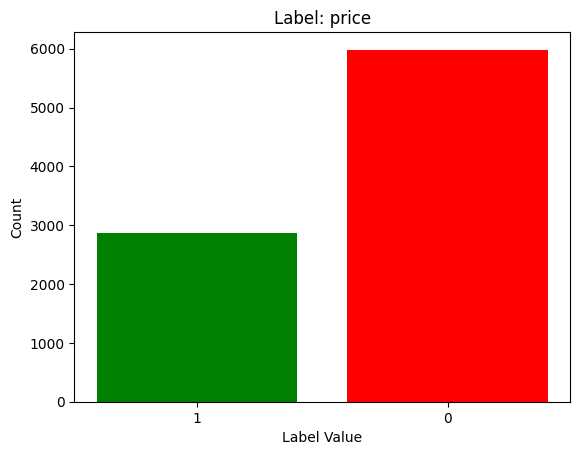

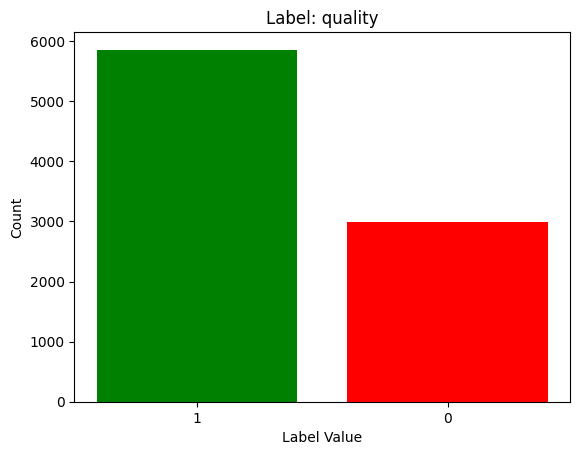

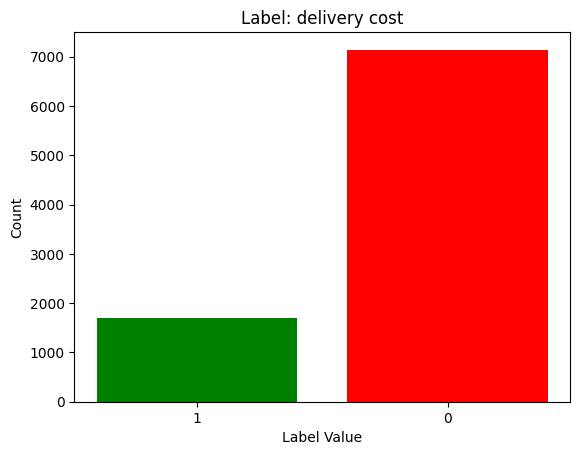

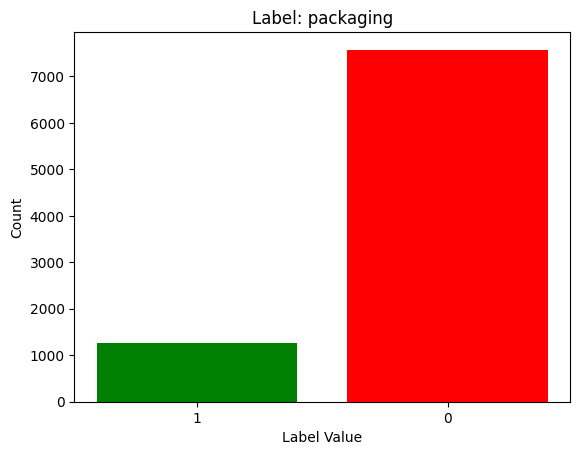

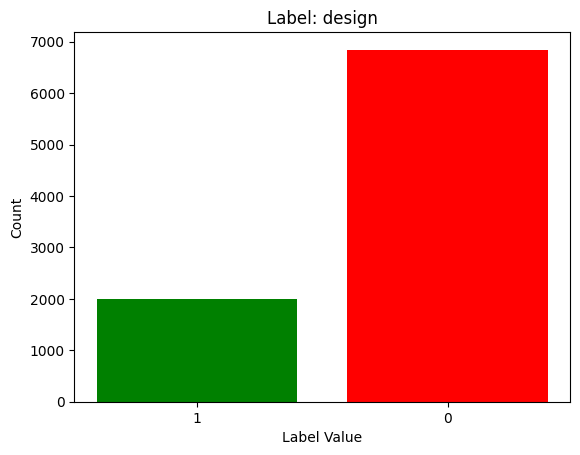

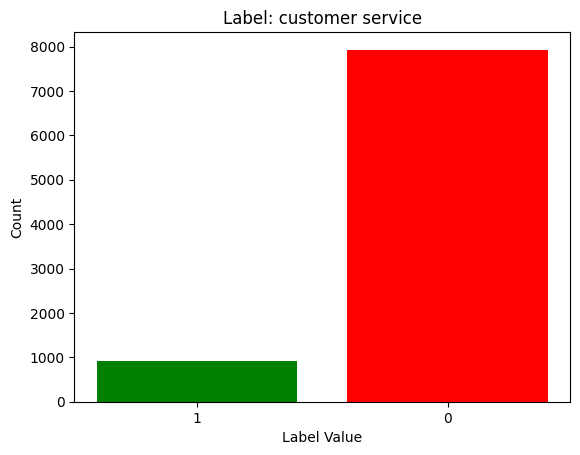

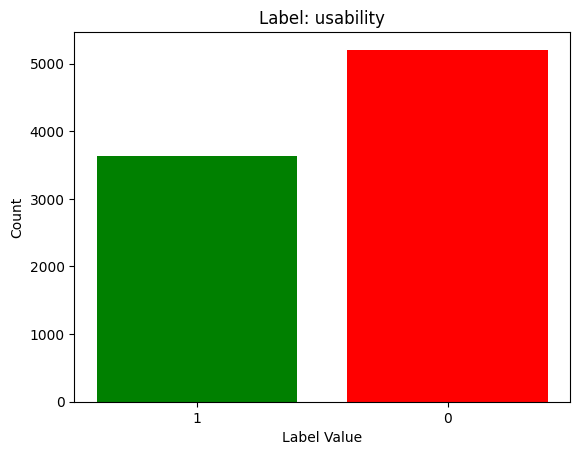

In [39]:
import matplotlib.pyplot as plt
# Count of 1 per label
label_counts_1 = df[label_cols].sum()

# Count of 0 per label
label_counts_0 = df[label_cols].eq(0).sum()

# Create separate graphs for each aspect label
colors_1 = ['green' for _ in range(num_labels)]  # Color for 1 values
colors_0 = ['red' for _ in range(num_labels)]    # Color for 0 values

for i, aspect_label in enumerate(label_cols):
    fig, ax = plt.subplots()
    ax.bar(['1', '0'], [label_counts_1[i], label_counts_0[i]], color=[colors_1[i], colors_0[i]])
    ax.set_xlabel('Label Value')
    ax.set_ylabel('Count')
    ax.set_title(f'Label: {aspect_label}')
    plt.show()

In [40]:
df = df.sample(frac=1).reset_index(drop=True) #shuffle rows

In [41]:
df['labels'] = list(df[label_cols].values)
df.head()

,preprocess_text,price,quality,delivery cost,packaging,design,customer service,usability,labels
0,the bottoms of the cups have ridges that made ...,1,1,1,0,0,0,0,"[1, 1, 1, 0, 0, 0, 0]"
1,i use them in a bowl beside my sink for food p...,0,1,0,0,0,0,1,"[0, 1, 0, 0, 0, 0, 1]"
2,i love it i use it in my laundry and i i no lo...,0,1,0,0,0,0,1,"[0, 1, 0, 0, 0, 0, 1]"
3,they are the same stir sticks that would be in...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0]"
4,better alot of them,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0]"


In [42]:
labels = list(df.labels.values)
comments = list(df.preprocess_text.values)

In [43]:
max_length = 128
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # tokenizer
encodings = tokenizer.batch_encode_plus(comments,max_length=max_length,pad_to_max_length=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/a265f773a47193eed794233aa2a0f0bb6d3eaa63/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/a265f773a47193eed794233aa2a0f0bb6d3eaa63/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/a265f773a47193eed794233aa2a0f0bb6d3eaa63/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_positio

tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [44]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

In [45]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts = df.labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df[df.labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  [8671, 8627, 8110, 7836, 6670, 6588, 3136, 2865, 2528, 1880]


In [46]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_token_types = [token_type_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

Be sure to handle all classes during validation using "stratify" during train/validation split:

In [47]:
# Use train_test_split to split our data into train and validation sets

train_inputs, validation_inputs, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks = train_test_split(input_ids, labels, token_type_ids,attention_masks,
                                                            random_state=2020, test_size=0.10, stratify = labels)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)
train_token_types.extend(one_freq_token_types)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

In [48]:
# Select a batch size for training. We will use 32 here to avoid memory issues.
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [49]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

## Load Model & Set Params

In [50]:
# Load model, the pretrained model will include a single linear classification layer on top for classification.
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model.cuda()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/a265f773a47193eed794233aa2a0f0bb6d3eaa63/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "trans

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Setting custom optimization parameters for the AdamW optimizer https://huggingface.co/transformers/main_classes/optimizer_schedules.html

In [51]:
# setting custom optimization parameters. You may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [52]:
optimizer = AdamW(optimizer_grouped_parameters,lr=3e-5,correct_bias=True)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Train Model

In [53]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs
epochs = 3

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss()
    loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    # loss_func = BCELoss()
    # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    train_loss_set.append(loss.item())

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  threshold = 0.50
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.3884601664231963


Epoch:  33%|███▎      | 1/3 [02:43<05:26, 163.44s/it]

F1 Validation Accuracy:  88.89538281706604
Flat Validation Accuracy:  68.77828054298642
Train loss: 0.14324914655053472


Epoch:  67%|██████▋   | 2/3 [05:26<02:43, 163.27s/it]

F1 Validation Accuracy:  93.8304721030043
Flat Validation Accuracy:  84.50226244343891
Train loss: 0.07278940260380387


Epoch: 100%|██████████| 3/3 [08:09<00:00, 163.19s/it]

F1 Validation Accuracy:  96.66666666666666
Flat Validation Accuracy:  90.72398190045249


In [54]:
import os

output_dir = os.path.expanduser('/content/drive/MyDrive/zidan/finetuned_bert')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print('Saved')

Configuration saved in /content/drive/MyDrive/zidan/finetuned_bert/config.json
Model weights saved in /content/drive/MyDrive/zidan/finetuned_bert/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/zidan/finetuned_bert/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/zidan/finetuned_bert/special_tokens_map.json


Saved


## Load and Preprocess Test Data

In [112]:
test_data.head()

,product_name,review,review_without_emoji,preprocess_text,preprocess_text1,aspects,price,quality,delivery cost,packaging,design,customer service,usability
1513,"Ziploc Gallon Food Storage Bags, Grip 'n Seal ...","I don’t know what they did to these bags, but ...","I don’t know what they did to these bags, but ...",i dont know what they did to these bags but on...,"['dont', 'know', 'bags', 'zipped', 'shut', 'ta...","['quality', 'usability']",0,1,0,0,0,0,1
6420,"Scotch-Brite Dobie Pads, Dobie Sponge for All ...",Our second order! works great,Our second order! works great,our second order works great,"['second', 'order', 'works', 'great']",['quality'],0,1,0,0,0,0,0
2979,Glad® Press'n Seal® Plastic Food Wrap - 100 Sq...,The wrap that keeps ones food fresh.\nHas been...,The wrap that keeps ones food fresh.\nHas been...,the wrap that keeps ones food fresh\nhas been ...,"['wrap', 'keeps', 'ones', 'food', 'fresh', 'ch...",[],0,0,0,0,0,0,0
4003,"Quickie Microfiber Cleaning Cloth, 14 X 14 in....",Gets all the dirt. Cleans glass and all surfa...,Gets all the dirt. Cleans glass and all surfa...,gets all the dirt cleans glass and all surfac...,"['gets', 'dirt', 'cleans', 'glass', 'surfaces'...",[],0,0,0,0,0,0,0
5938,OZCHIN Smell Proof Bag with Combination Lock S...,I travel a lot for work so this works perfect ...,I travel a lot for work so this works perfect ...,i travel a lot for work so this works perfect ...,"['travel', 'lot', 'work', 'works', 'perfect', ...","['price', 'quality']",1,1,0,0,0,0,0


In [113]:
columns_to_drop = ['product_name', 'aspects', 'review','review_without_emoji','preprocess_text1']
test_data.drop(columns_to_drop, axis=1, inplace=True)

test_label_cols = list(test_data.columns[1:])
print('Null values:', test_data.isnull().values.any())  # Should not be any null sentences or labels
print('Same columns between train and test:', label_cols == test_label_cols)  # Columns should be the same

test_data[test_label_cols] = -1  # Set label column values to -1

test_data.head()


Null values: False
Same columns between train and test: True


,preprocess_text,price,quality,delivery cost,packaging,design,customer service,usability
1513,i dont know what they did to these bags but on...,-1,-1,-1,-1,-1,-1,-1
6420,our second order works great,-1,-1,-1,-1,-1,-1,-1
2979,the wrap that keeps ones food fresh\nhas been ...,-1,-1,-1,-1,-1,-1,-1
4003,gets all the dirt cleans glass and all surfac...,-1,-1,-1,-1,-1,-1,-1
5938,i travel a lot for work so this works perfect ...,-1,-1,-1,-1,-1,-1,-1


In [114]:
test_data = test_data.replace(-1, 0)  # Change -1 to 0 in the entire DataFrame

test_data = test_data[~test_data[test_label_cols].eq(-1).any(axis=1)]  # Remove irrelevant rows/comments with -1 values
test_data['labels'] = list(test_data[test_label_cols].values)
test_data.head()


,preprocess_text,price,quality,delivery cost,packaging,design,customer service,usability,labels
1513,i dont know what they did to these bags but on...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0]"
6420,our second order works great,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0]"
2979,the wrap that keeps ones food fresh\nhas been ...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0]"
4003,gets all the dirt cleans glass and all surfac...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0]"
5938,i travel a lot for work so this works perfect ...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0]"


In [115]:
# Gathering input data
test_labels = list(test_data.labels.values)
test_comments = list(test_data.preprocess_text.values)

In [116]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(test_comments,max_length=max_length,pad_to_max_length=True)
test_input_ids = test_encodings['input_ids']
test_token_type_ids = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [117]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
test_token_types = torch.tensor(test_token_type_ids)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

## Prediction and Metics

In [118]:
# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

# Variables to gather full output
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(validation_dataloader):
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, b_token_types = batch
  with torch.no_grad():
    # Forward pass
    outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()
    b_labels = b_labels.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  true_labels.append(b_labels)
  pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]

# Calculate Accuracy
threshold = 0.50
pred_bools = [pl>threshold for pl in pred_labels]
true_bools = [tl==1 for tl in true_labels]
f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
flat_accuracy = accuracy_score(true_bools, pred_bools)*100

print('Test F1 Accuracy: ', val_f1_accuracy)
print('Test Flat Accuracy: ', val_flat_accuracy)

clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report

Test F1 Accuracy:  96.66666666666666
Test Flat Accuracy:  90.72398190045249


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Output Dataframe

In [119]:
idx2label = dict(zip(range(7),label_cols))
print(idx2label)

{0: 'price', 1: 'quality', 2: 'delivery cost', 3: 'packaging', 4: 'design', 5: 'customer service', 6: 'usability'}


In [120]:
# Getting indices of where boolean one hot vector true_bools is True so we can use idx2label to gather label names
true_label_idxs, pred_label_idxs=[],[]
for vals in true_bools:
  true_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in pred_bools:
  pred_label_idxs.append(np.where(vals)[0].flatten().tolist())

In [121]:
# Gathering vectors of label names using idx2label
true_label_texts, pred_label_texts = [], []
for vals in true_label_idxs:
  if vals:
    true_label_texts.append([idx2label[val] for val in vals])
  else:
    true_label_texts.append(vals)

for vals in pred_label_idxs:
  if vals:
    pred_label_texts.append([idx2label[val] for val in vals])
  else:
    pred_label_texts.append(vals)

In [122]:
# Decoding input ids to reviews
reviews = [tokenizer.decode(text,skip_special_tokens=True,clean_up_tokenization_spaces=False) for text in tokenized_texts]

In [123]:
# Converting lists to df
comparisons_df = pd.DataFrame({'reviews': reviews,'pred_labels':pred_label_texts})
comparisons_df.to_csv('/content/drive/MyDrive/zidan/test_predictions.csv')
comparisons_df


,reviews,pred_labels
0,there are many possible options for these napk...,"[price, quality]"
1,for salads and other lunches i wanted to be ab...,[]
2,when you need a good quality soap meyerss soap...,"[price, quality]"
3,son buenas,[]
4,they work very well last a nice long time grea...,"[quality, delivery cost]"
...,...,...
879,i was pricing plates napkins etc separately an...,"[price, quality, delivery cost, packaging]"
880,just received it today i have one the black an...,"[price, customer service, usability]"
881,i liked the price and quantity,[price]
882,just like it is listed,[]
